# Extension: Ocetrac

## Set up

In [1]:
# Import packages
import numpy as np
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from dask import delayed
import pandas as pd 
from numpy.linalg import pinv
import psutil

import gc
import imageio.v2 as imageio
import glob

import dask.array as da
from dask.diagnostics import ProgressBar

In [ ]:
from utils import cesm2_lens_utils
# also contains compute_dask_quantile, get_xarray_memory_usage
from utils import compute_time_memory
from utils import tracker_subsurface #subsurface_tracking

In [2]:
def compute_dask_quantile(anom_data, q=0.9):
    """Compute quantile using Dask's parallelized algorithm"""
    # Convert to dask array (preserving chunks)
    dask_array = anom_data.data
    
    # Compute quantile along time axis (axis=0 for xarray's time dimension)
    quantile_array = da.quantile(
        dask_array,
        q=q,
        axis=0,  # Corresponds to time dimension
        method='linear',
        keepdims=False
    )
    
    # Convert back to xarray with original coordinates
    return xr.DataArray(
        quantile_array,
        dims=anom_data.dims[1:],  # Remove time dimension
        coords={k: v for k, v in anom_data.coords.items() if k != 'time'}
    )

In [3]:
def get_xarray_memory_usage():
    """Returns memory usage of xarray objects."""
    mem_usage = []
    for var_name, var_value in globals().items():
        if isinstance(var_value, (xr.DataArray, xr.Dataset)):
            size_mb = var_value.nbytes / (1024 ** 2)  # MB
            mem_usage.append({
                'Variable': var_name,
                'Type': type(var_value).__name__,
                'Size (MB)': round(size_mb, 2)
            })
    return pd.DataFrame(mem_usage).sort_values('Size (MB)', ascending=False)

## Access and load data

In [4]:
# Ensemble member index (0 = first member)
ens_memb_index = 0

In [7]:
%%time
## ACCESSING CESM SAVED VARIABLE TEMP
# Define variable name and component
var = 'TEMP'       # Variable of interest (Ocean Temperature)
comp = 'ocn'       # Model component (ocean)
directory = f'/glade/campaign/cgd/cesm/CESM2-LE/{comp}/proc/tseries/month_1/{var}/'

ens_memb_index = 0

# Load historical and future datasets using utility function
ds_var_hist_var, ds_var_fut_var = cesm2_lens_utils.get_ds_var(
    directory,
    var,
    comp,
    ens_memb_index)

nlat_low = 26
nlat_high = 354

ds = ds_var_hist_var.TEMP.isel(
    z_t =slice(0,26), # upper 300 m
    nlat=slice(26,354)).sel(
    time=slice('1979-01','2015-01')) # 40 years

ds = ds.compute() # about 1 minute 30 seconds
# ds_noland = ds.where(ds != 0, np.nan) # mask out invalid data

CPU times: user 26.3 s, sys: 1.54 s, total: 27.8 s
Wall time: 1min 7s


In [9]:
del ds_var_fut_var
del ds_var_hist_var
gc.collect()

9549

In [10]:
print(f"Memory after cleanup (GB): {psutil.Process().memory_info().rss / 1024**3:.2f}")

Memory after cleanup (GB): 11.46


## Compute anomalies and features

In [11]:
%%time
## COMPUTING ANOMALIES
dyr = ds.time.dt.year + ds.time.dt.month/12

# Create the 6-coefficient model matrix
model = np.array([
        np.ones(len(dyr)),
        dyr - np.mean(dyr),
        np.sin(2*np.pi*dyr),
        np.cos(2*np.pi*dyr),
        np.sin(4*np.pi*dyr),
        np.cos(4*np.pi*dyr)
    ])

# Convert to DataArrays
model_da = xr.DataArray(
        model.T,
        dims=['time', 'coeff'],
        coords={'time': ds.time, 'coeff': np.arange(1, 7)}
    )

pmodel = xr.apply_ufunc(
    pinv,
    model_da,
    input_core_dims=[['coeff', 'time']], # Input dimensions
    output_core_dims=[['time', 'coeff']], # Output dimensions
    dask='parallelized',
    output_dtypes=[np.float64],
    dask_gufunc_kwargs={
        'output_sizes': {'time': len(ds.time), 'coeff': 6}
    }
)

coeffs = xr.dot(pmodel, ds, dims=['time'])
full_model = model_da.dot(coeffs)
temp_anom = (ds - full_model).chunk({'time': -1, 'z_t': 5, 'nlat': 50, 'nlon': 50})

threshold = compute_dask_quantile(temp_anom, 0.9)

CPU times: user 10.1 s, sys: 2.11 s, total: 12.2 s
Wall time: 13.8 s


In [12]:
%%time
with ProgressBar():
    threshold_map = threshold.compute()

[########################################] | 100% Completed | 13.29 s
CPU times: user 12.3 s, sys: 41.3 ms, total: 12.3 s
Wall time: 13.3 s


In [13]:
%%time
with ProgressBar():
    features_notrend = temp_anom.where(temp_anom >= threshold_map).compute()

[########################################] | 100% Completed | 101.98 ms
[########################################] | 100% Completed | 103.64 ms
[########################################] | 100% Completed | 104.19 ms
[########################################] | 100% Completed | 104.78 ms
[########################################] | 100% Completed | 103.71 ms
[########################################] | 100% Completed | 103.15 ms
[########################################] | 100% Completed | 103.87 ms
[########################################] | 100% Completed | 103.88 ms
[########################################] | 100% Completed | 5.58 sms
CPU times: user 6.36 s, sys: 1.13 s, total: 7.49 s
Wall time: 8.8 s


In [16]:
print(f"Memory before cleanup (GB): {psutil.Process().memory_info().rss / 1024**3:.2f}")

Memory before cleanup (GB): 41.96


In [15]:
print(get_xarray_memory_usage())

            Variable       Type  Size (MB)
0                 __    Dataset   87256.17
1                 _6    Dataset   87256.17
8          temp_anom  DataArray    9015.20
7         full_model  DataArray    9015.20
11  features_notrend  DataArray    9015.20
2                 ds  DataArray    4507.60
6             coeffs  DataArray     124.92
9          threshold  DataArray      20.82
10     threshold_map  DataArray      20.82
4           model_da  DataArray       0.02
5             pmodel  DataArray       0.02
3                dyr  DataArray       0.00


In [17]:
del __
del _6
del full_model
del ds
del coeffs
del threshold
del threshold_map
del model_da
del pmodel
gc.collect()

19645

In [18]:
print(f"Memory after cleanup (GB): {psutil.Process().memory_info().rss / 1024**3:.2f}")

Memory after cleanup (GB): 24.67


## Ocetrac

In [28]:
%%time
tracker = tracker_subsurface.OceanFeatureTracker(
    features_notrend[:100,:,:,:], 
    radius=3, 
    positive=True)
results = tracker.track_features() # only vertical tracking here
labeled_3d = xr.where(results == 0, np.nan, results)

CPU times: user 19.1 s, sys: 851 ms, total: 19.9 s
Wall time: 21 s


In [32]:
print(labeled_3d.max().item()) # 6188.0 objects for the first 100 timesteps

6188.0


In [ ]:
labeled_3d = xr.where(results == 0, np.nan, results)

In [34]:
%%time
final_labels = tracker_subsurface.simple_temporal_connection(labeled_3d)

CPU times: user 10.5 s, sys: 168 ms, total: 10.7 s
Wall time: 11.4 s


In [63]:
final_labels = xr.where(final_labels == 0, np.nan, final_labels)

In [70]:
print(final_labels.max().item()) # 2046.0 events

2046.0


In [38]:
print(f"Memory before cleanup (GB): {psutil.Process().memory_info().rss / 1024**3:.2f}")

Memory before cleanup (GB): 30.91


0


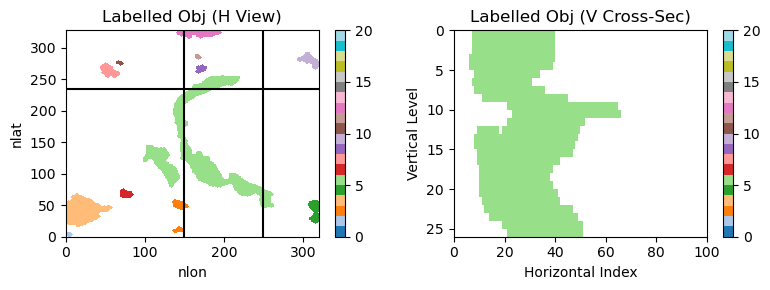

In [62]:
for time_step in range(0,1):
    print(time_step)
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    
    # First plot (pcolormesh)
    ax1.set_title('Labelled Obj (H View)', fontsize=12)
    ax1.axhline(y=235, c='k')
    ax1.axvline(x=150, c='k')
    ax1.axvline(x=250, c='k')
    mesh = ax1.pcolormesh(labeled_3d[time_step,0,:,:], cmap='tab20', vmin=0, vmax=20)
    fig.colorbar(mesh, ax=ax1)
    ax1.set_xlabel('nlon')
    ax1.set_ylabel('nlat')
    
    # Second plot (contourf)
    ax2.set_title('Labelled Obj (V Cross-Sec)', fontsize=12)
    contour = ax2.pcolormesh(labeled_3d[
                             time_step,:, 235,150:250], 
                             vmin=0, vmax=20, cmap='tab20')
    ax2.invert_yaxis()
    fig.colorbar(contour, ax=ax2)
    ax2.set_xlabel('Horizontal Index')
    ax2.set_ylabel('Vertical Level')
    
    plt.tight_layout()
    plt.show()

0


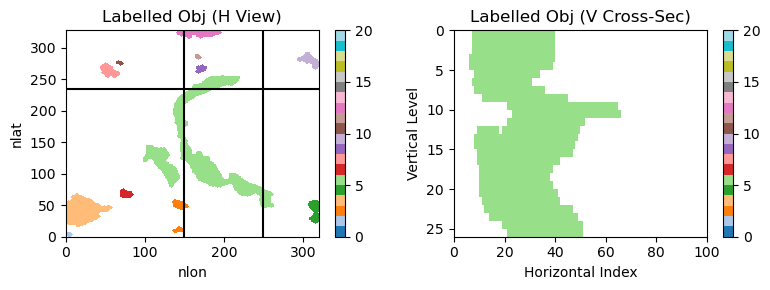

1


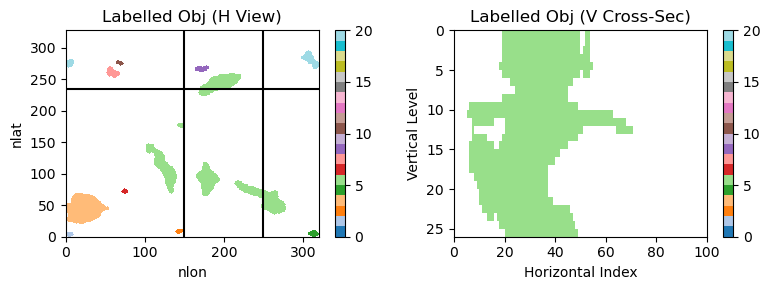

2


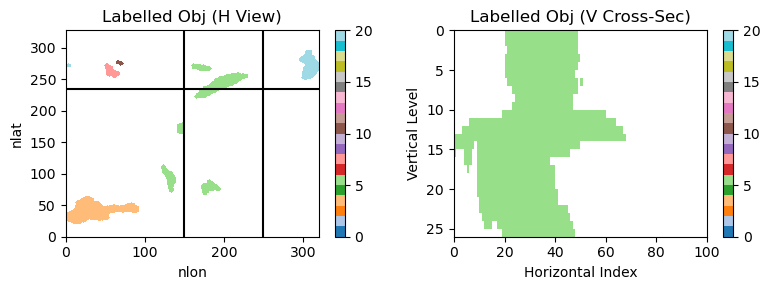

3


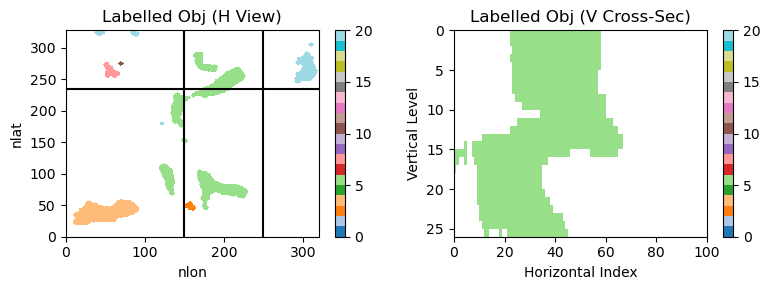

4


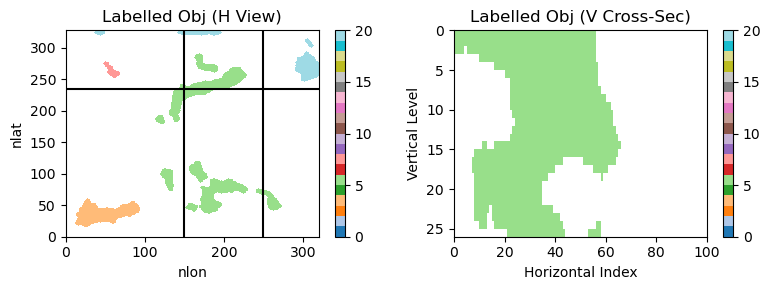

5


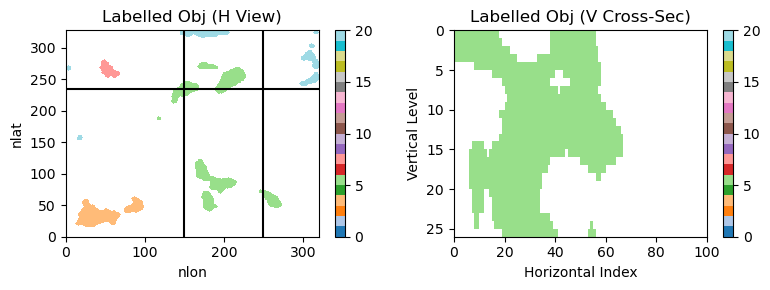

6


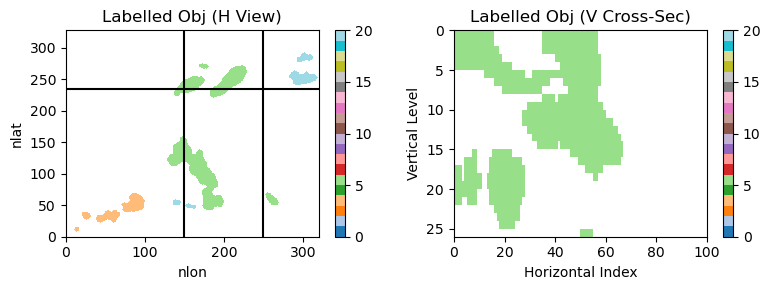

7


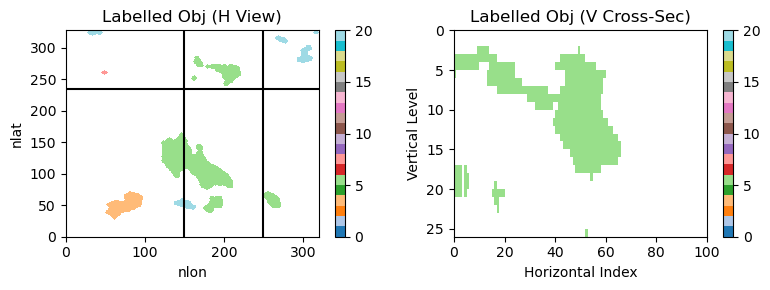

8


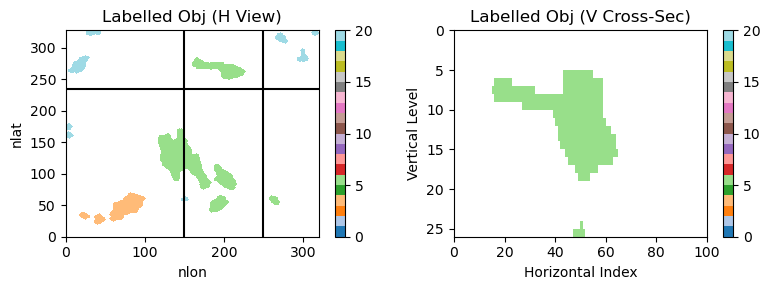

9


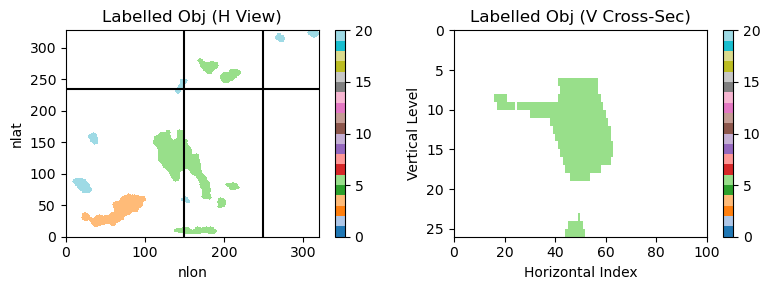

In [65]:
for time_step in range(0,10):
    print(time_step)
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    
    # First plot (pcolormesh)
    ax1.set_title('Labelled Obj (H View)', fontsize=12)
    ax1.axhline(y=235, c='k')
    ax1.axvline(x=150, c='k')
    ax1.axvline(x=250, c='k')
    mesh = ax1.pcolormesh(final_labels[time_step,0,:,:], cmap='tab20', vmin=0, vmax=20)
    fig.colorbar(mesh, ax=ax1)
    ax1.set_xlabel('nlon')
    ax1.set_ylabel('nlat')
    
    # Second plot (contourf)
    ax2.set_title('Labelled Obj (V Cross-Sec)', fontsize=12)
    contour = ax2.pcolormesh(final_labels[
                             time_step,:, 235,150:250], 
                             vmin=0, vmax=20, cmap='tab20')
    ax2.invert_yaxis()
    fig.colorbar(contour, ax=ax2)
    ax2.set_xlabel('Horizontal Index')
    ax2.set_ylabel('Vertical Level')
    
    plt.tight_layout()
    plt.show()

## Visualization

In [96]:
one_object = xr.where(final_labels == 2., 1., 0)
time_steps = one_object.max(dim=('z_t', 'nlat','nlon'))
where_one_obj_exists = np.argwhere(time_steps.data == 1.)

/glade/derecho/scratch/cassiacai/tmp/ipykernel_69234/499925568.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6, 4))


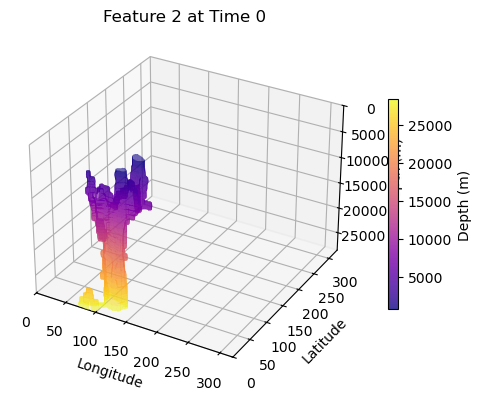

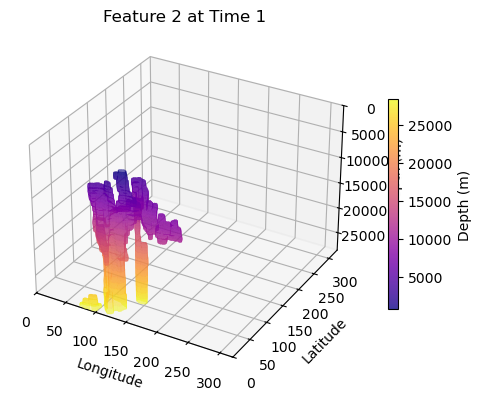

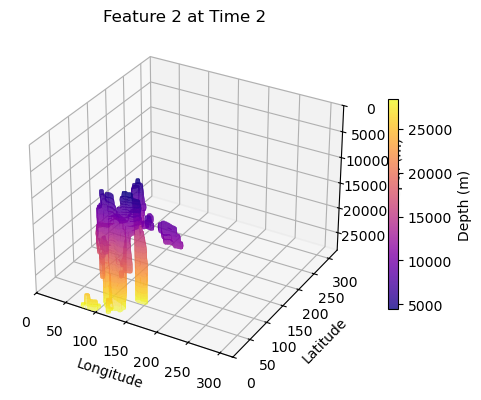

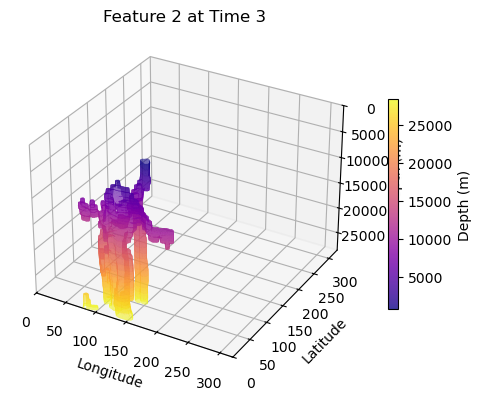

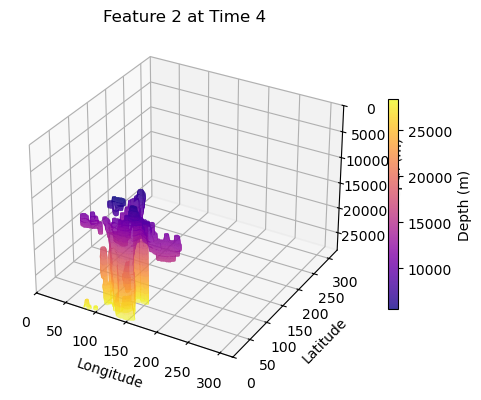

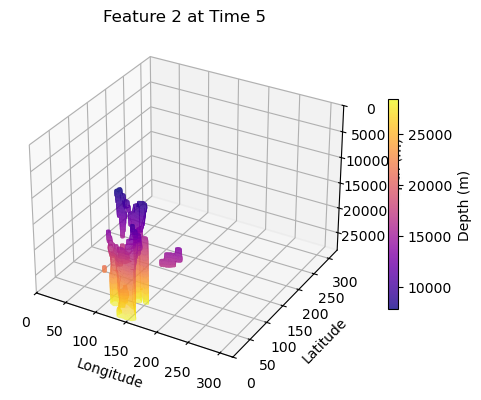

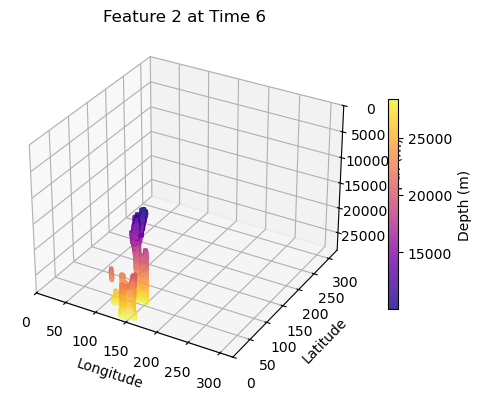

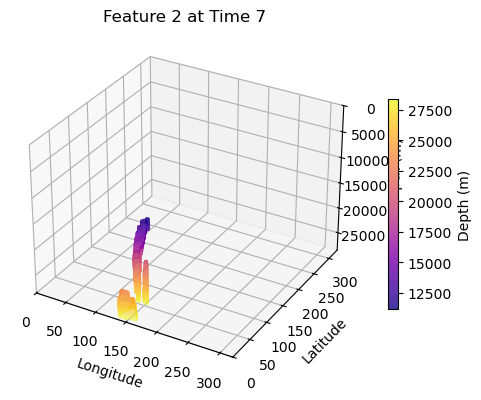

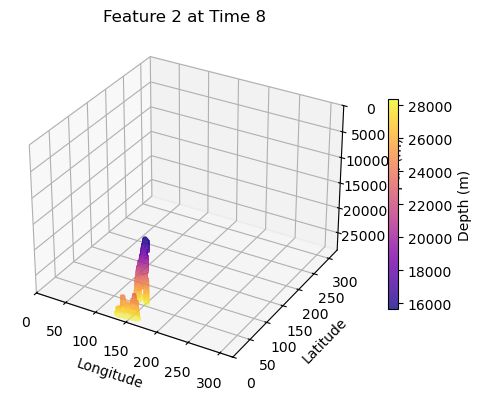

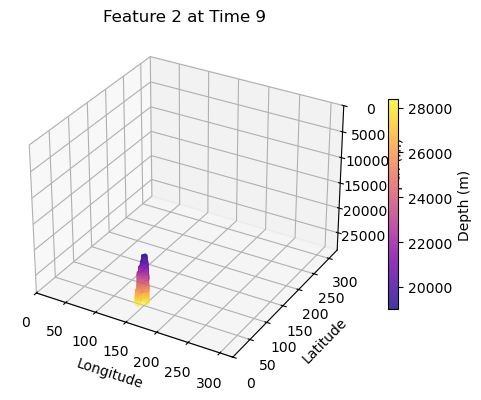

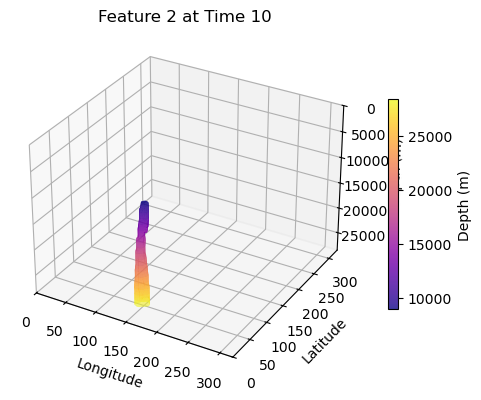

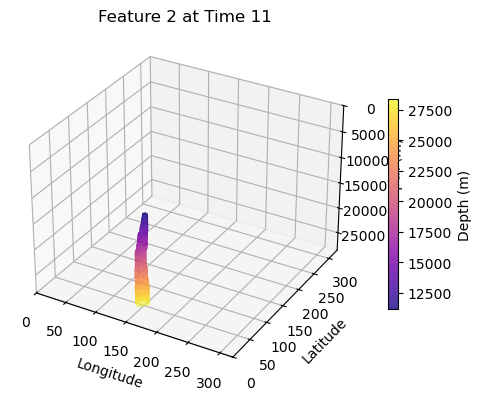

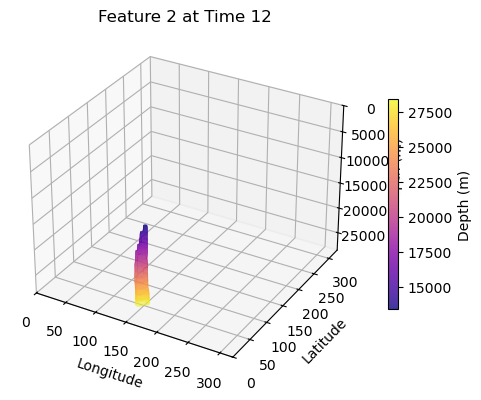

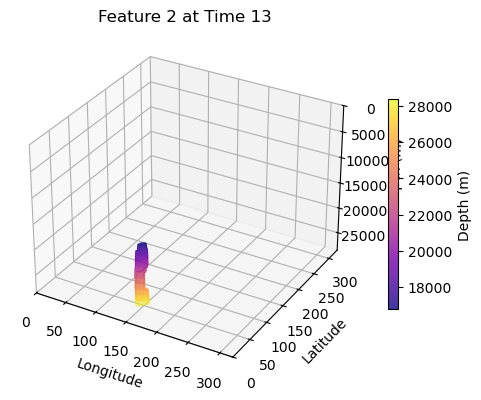

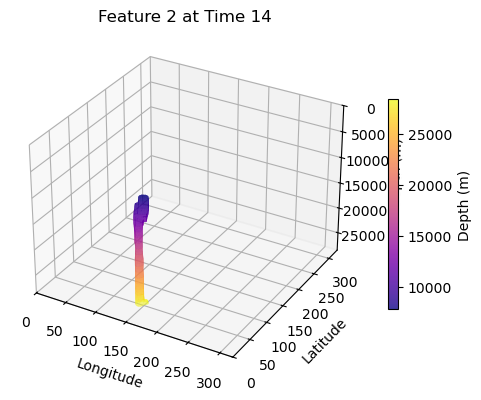

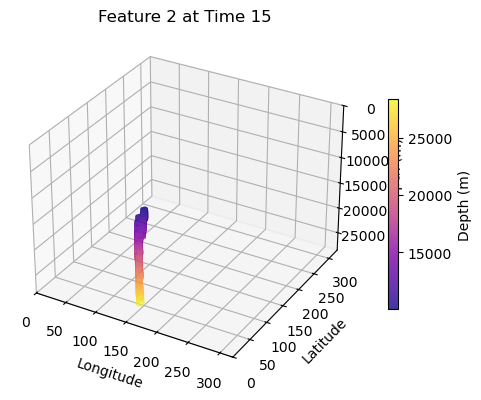

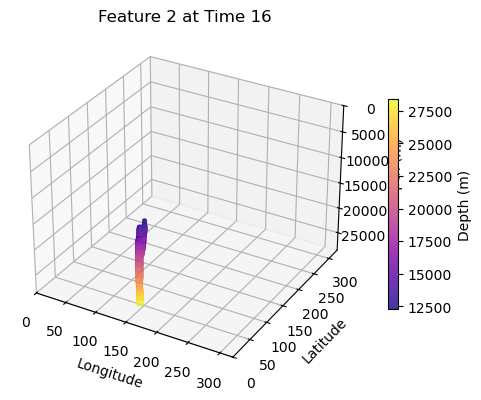

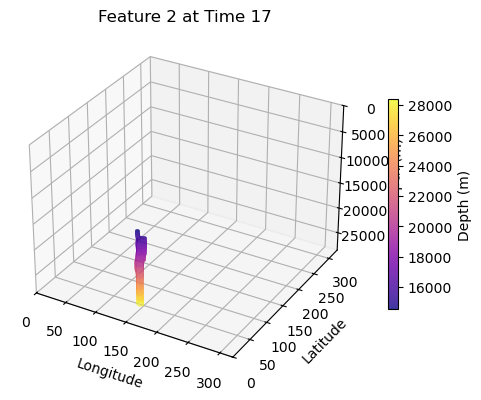

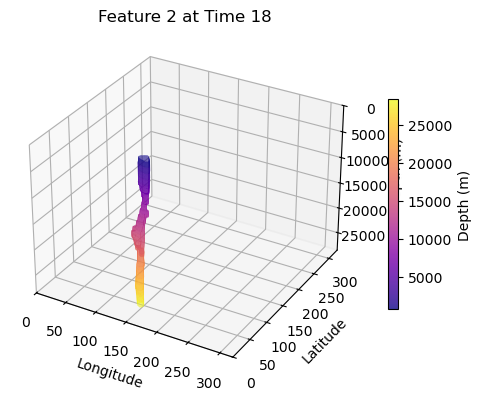

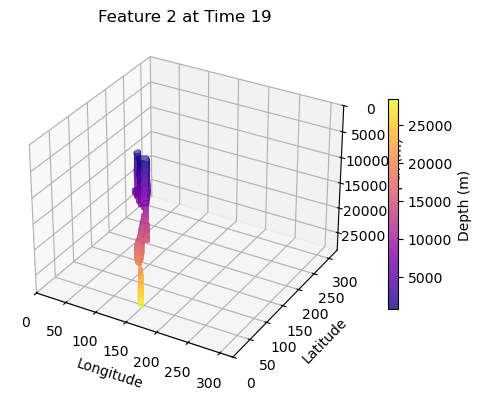

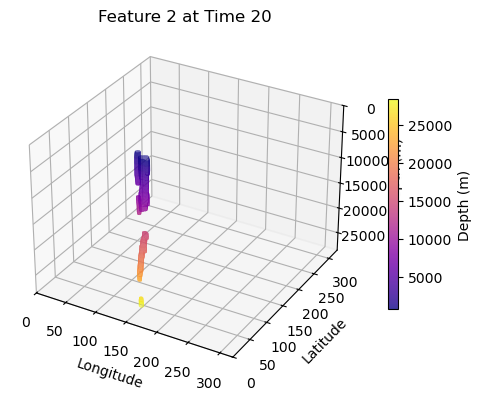

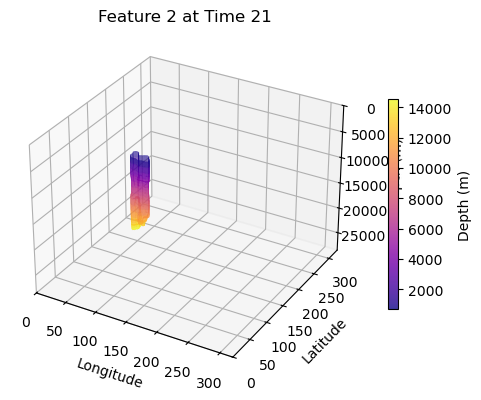

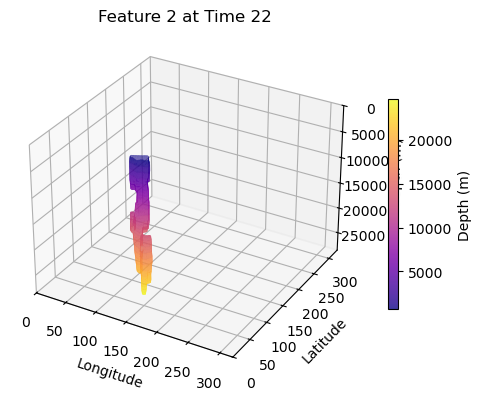

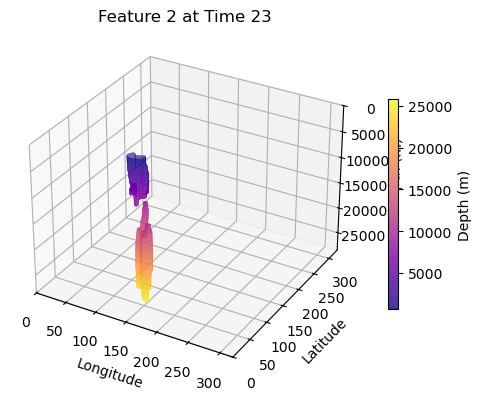

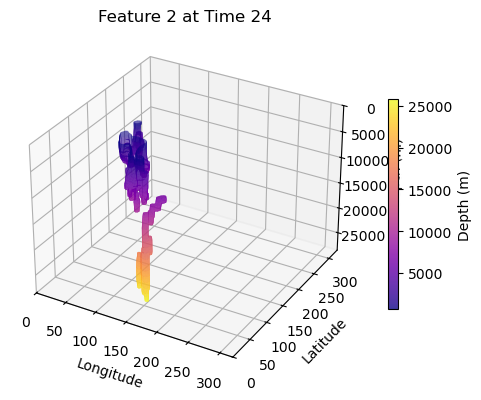

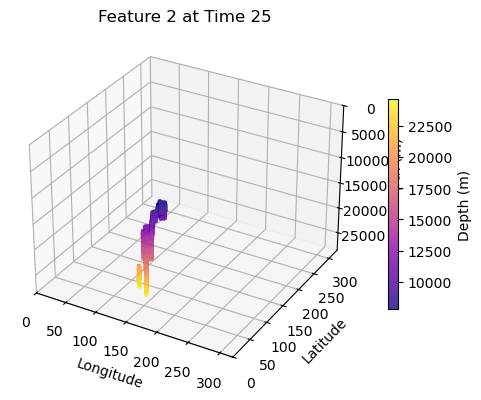

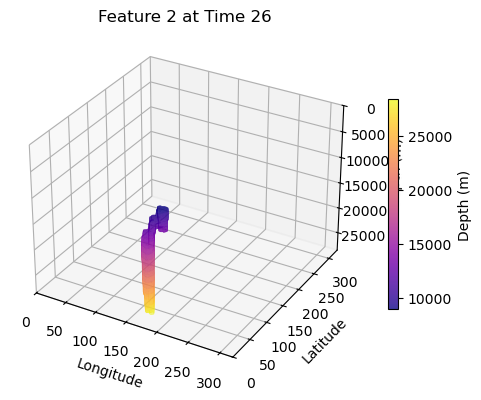

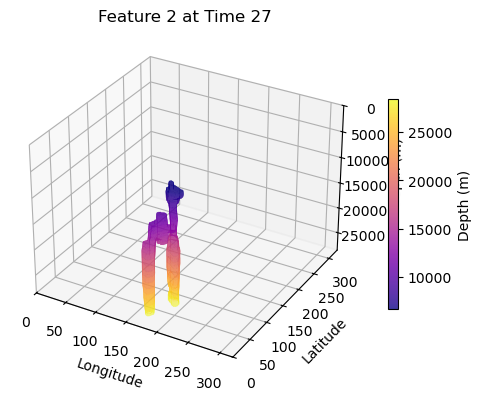

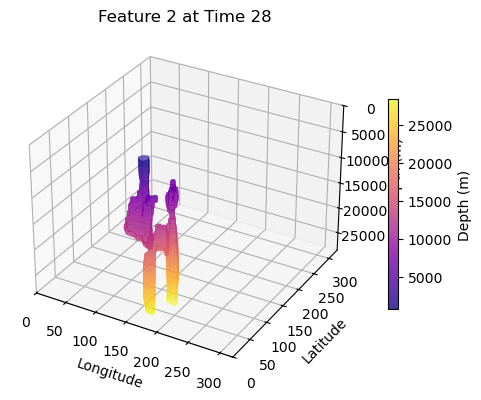

In [125]:
for timestep in range(where_one_obj_exists.min(), where_one_obj_exists.max()):
    plot_3d_labeled_feature(final_labels, feature_id=2, time_idx=timestep)

In [128]:
time_range = range(where_one_obj_exists.min(), where_one_obj_exists.max())
save_3d_feature_frames(final_labels, feature_id=2, time_range=time_range)

frames = sorted(glob.glob("frames/*.png"))
with imageio.get_writer('feature_evolution.gif', mode='I', duration=1000, loop=0) as writer:
    for frame in frames:
        writer.append_data(imageio.imread(frame))

In [ ]:
import numpy as np
import xarray as xr
from scipy import ndimage
import dask.array as dsa
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

class OceanFeatureTracker:
    def __init__(self, da, radius=3, positive=True):
        """Initialize tracker with parameters
        
        Args:
            da (xarray.DataArray): Input data array (4D: time, depth, y, x)
            radius (int): Size of morphological operations
            positive (bool): Whether to track positive (True) or negative (False) features
        """
        self.da = da                # Input 4D xarray.DataArray (time, depth, y, x)
        self.radius = radius        # Radius for morphological structuring element
        self.positive = positive    # Whether to track positive or negative features
        
    def make_struct(self, connect_xy='full', connect_z=True, connect_time='none'):
        """Create 4D connectivity structure"""
        struct = np.zeros((3,3,3,3), dtype=bool) # 4D array: (time, depth, y, x)
        struct[1,1,1,1] = True # Always include the center point
        
        # --- XY Connectivity ---
        if connect_xy == 'limited':  # 4-connected
            # 4-connectivity in horizontal (left/right and up/down only)
            struct[1,1,1,0] = struct[1,1,1,2] = True  # X axis
            struct[1,1,0,1] = struct[1,1,2,1] = True  # Y axis
        elif connect_xy == 'full':  
            # 8-connectivity in horizontal (all neighbors in XY plane)
            struct[1,1,:,:] = True  # Full XY plane
        
        # --- Z Connectivity (depth) ---
        if connect_z:
            # Connect vertically in Z (depth axis)
            struct[1,:,1,1] = True 
        return struct

    def _morphological_operations(self):
        """Clean binary features with morphological ops"""
        # Convert data to binary: 1 if >0 (or <0 if negative tracking), else 0
        binary = xr.where(self.da > 0 if self.positive else self.da < 0, 1, 0)

        # Create circular structuring element
        y, x = np.ogrid[-self.radius:self.radius+1, -self.radius:self.radius+1]
        se = x**2 + y**2 <= self.radius**2

        # Process each 2D slice
        def process_slice(slice_2d):
            padded = np.pad(slice_2d, self.radius, mode='wrap') # wrap around edges
            closed = ndimage.binary_closing(padded, structure=se) # fill small holes 
            opened = ndimage.binary_opening(closed, structure=se) # remove small blobs
            return opened[self.radius:-self.radius, self.radius:-self.radius]

        # Apply to all slices
        if isinstance(binary.data, dsa.Array): # Dask array: compute in memory
            binary = binary.compute()

        # Iterate over time and depth, apply cleaning slice-by-slice
        cleaned = np.stack([
            np.stack([process_slice(binary[t,z].values) 
            for z in range(binary.shape[1])])
            for t in range(binary.shape[0])
        ])
        
        return xr.DataArray(cleaned, dims=self.da.dims, coords=self.da.coords)
    
    def track_features(self):
        """Complete tracking workflow"""
        # Step 1: Clean features using morphological operations
        binary = self._morphological_operations()

        # Step 2: Create connectivity structure
        struct = self.make_struct()

        # Step 3: Label connected features using 4D connectivity
        labels, _ = ndimage.label(binary.values, structure=struct)
        
        return xr.DataArray(
            labels,
            dims=self.da.dims,
            coords=self.da.coords,
            name='feature_labels'
        ).where(labels != 0, np.nan) # Replace 0s with NaN for clarity

def simple_temporal_connection(labeled_3d):
    """Connect features across time with minimal indexing"""
    arr = labeled_3d.values
    
    # Initialize output
    connected = np.full_like(arr, np.nan)
    next_label = 1
    label_map = {}
    
    for t in range(arr.shape[0]):
        if t == 0:
            # First timestep - keep original labels
            unique_labels = np.unique(arr[0])
            unique_labels = unique_labels[~np.isnan(unique_labels)]
            
            for lbl in unique_labels:
                mask = arr[0] == lbl
                connected[0][mask] = next_label
                label_map[(0, lbl)] = next_label
                next_label += 1
        else:
            current = arr[t]
            prev = connected[t-1]
            unique_labels = np.unique(current)
            unique_labels = unique_labels[~np.isnan(unique_labels)]
            
            for lbl in unique_labels:
                mask = current == lbl
                overlapping = prev[mask]
                overlapping_labels = overlapping[~np.isnan(overlapping)]
                
                if len(overlapping_labels) > 0:
                    # Use most common overlapping label
                    best_match = np.argmax(np.bincount(overlapping_labels.astype(int)))
                    connected[t][mask] = best_match
                else:
                    # New feature
                    connected[t][mask] = next_label
                    next_label += 1

    # Convert back to xarray with original coordinates
    return xr.DataArray(
        connected,
        dims=labeled_3d.dims,
        coords=labeled_3d.coords,
        name='connected_labels'
    )
## VISUALIZATION

import os
import imageio.v2 as imageio
import glob

def plot_3d_labeled_feature(label_da, feature_id, time_idx=0, threshold=0.5, sigma=0):
    """
    Extract and plot a labeled 3D feature at a given time index.
    """
    # Extract 3D data at the time index
    label_3d = label_da.isel(time=time_idx).values
    mask = np.nan_to_num((label_3d == feature_id).astype(float))  # 1s for feature, 0 elsewhere

    if mask.sum() == 0:
        print(f"Feature {feature_id} not found at time index {time_idx}.")
        return

    # Optional smoothing
    if sigma > 0:
        from scipy.ndimage import gaussian_filter
        mask = gaussian_filter(mask, sigma=sigma)

    # Extract surface
    verts, faces, _, _ = measure.marching_cubes(mask, level=threshold)

    # Get real coordinates from xarray
    z_vals = label_da.z_t.values
    y_vals = label_da.nlat.values
    x_vals = label_da.nlon.values

    dz = (z_vals[-1] - z_vals[0]) / (len(z_vals) - 1)
    dy = (y_vals[-1] - y_vals[0]) / (len(y_vals) - 1)
    dx = (x_vals[-1] - x_vals[0]) / (len(x_vals) - 1)

    z0, y0, x0 = z_vals[0], y_vals[0], x_vals[0]
    verts_phys = np.zeros_like(verts)
    verts_phys[:, 0] = z0 + verts[:, 0] * dz
    verts_phys[:, 1] = y0 + verts[:, 1] * dy
    verts_phys[:, 2] = x0 + verts[:, 2] * dx

    # Plot
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(
        verts_phys[:, 2],  # longitude (x)
        verts_phys[:, 1],  # latitude (y)

            faces,
        verts_phys[:, 0],  # depth (z)
        cmap='plasma',
        edgecolor='none',
        alpha=0.8
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_zlabel("Depth (m)")
    ax.set_title(f"Feature {feature_id} at Time {time_idx}")
    ax.set_ylim(0, 328)
    ax.set_xlim(0, 320)
    ax.set_zlim(0, 28548.36523438)
    ax.invert_zaxis()
    
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6)
    cbar.set_label("Depth (m)")
    plt.tight_layout()
    return fig  # Return figure for GIF creation

def save_3d_feature_frames(label_da, feature_id, time_range, output_dir="frames"):
    os.makedirs(output_dir, exist_ok=True)
    for time_idx in time_range:
        fig = plot_3d_labeled_feature(label_da, feature_id, time_idx)
        fig.savefig(f"{output_dir}/frame_{time_idx:03d}.png", dpi=100)
        plt.close(fig)

## Filtering out objects using a 75th percentile volume threshold
## Voxel (volumes)

In [130]:
# Load historical and future datasets using utility function
ds_var_hist_var, ds_var_fut_var = cesm2_lens_utils.get_ds_var(
    directory,var,comp,ens_memb_index)

In [132]:
# Calculate voxel areas
dz_cm = ds_var_hist_var.dz[0,:15].compute()
TAREA_cm2 = ds_var_hist_var.TAREA[0,:,:].compute()
volume_per_voxel = dz_cm*TAREA_cm2

region_volume_per_voxel = volume_per_voxel.sel(
    nlat=slice(nlat_low,nlat_high))

In [ ]:
%%time
# Step 1: Precompute the mask for all labels at once (vectorized)
labels = final_labels.values  # Convert to numpy array for faster masking
unique_labels = np.unique(labels[~np.isnan(labels)])  # Get non-NaN labels

# Step 2: Compute volumes in one go (avoid loop over labels)
# (Assumes 'region_volume_per_voxel' is a compatible xarray DataArray)
feature_volumes = {}
for label in unique_labels:
    if label == 0:  # Skip background (if needed)
        continue
    mask = (labels == label).astype(float)  # Faster than xr.where
    event_volume = mask * region_volume_per_voxel.values  # Use numpy arrays
    vol_timeseries = event_volume.sum(axis=(1, 2, 3))  # Sum over spatial dims
    feature_volumes[label] = np.max(vol_timeseries)  # Max over time

In [179]:
%%time
feature_volumes = {}
# for label in range(final_labels.max().item()):
for label in range(1,100): # approximately 2 minutes for 100 objects
    print(label)
    one_object = xr.where(final_labels == label, 1., 0)
    event_volume = one_object*region_volume_per_voxel
    vol_timeseries = event_volume.sum(dim=('nlat','nlon', 'z_t'))
    if len(vol_timeseries) > 1:
        feature_volumes[label] = vol_timeseries.max()
    else:
        feature_volumes[label] = vol_timeseries

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 57.1 s, sys: 58.4 s, total: 1min 55s
Wall time: 2min 2s


In [ ]:
%%time
# Step 1: Precompute the mask for all labels at once (vectorized)
labels = final_labels.values  # Convert to numpy array for faster masking
unique_labels = np.unique(labels[~np.isnan(labels)])  # Get non-NaN labels

feature_volumes = {}
for label in range(0,100):#unique_labels:
    print(label)
    if label == 0: 
        continue
    mask = (labels == label).astype(float)  # Faster than xr.where
    event_volume = mask * region_volume_per_voxel.values  # Use numpy arrays
    vol_timeseries = event_volume.sum(axis=(1, 2, 3))  # Sum over spatial dims
    feature_volumes[label] = np.max(vol_timeseries)  # Max over time

0
1


In [206]:
volumes = np.array(list(feature_volumes.values()))
volume_threshold = np.percentile(volumes[volumes>0], 25)  # 25th percentile volume
filtered_arr = volumes[volumes > volume_threshold]  # Keep values > threshold

print("Original array size:", len(volumes))
print("Filtered array size:", len(filtered_arr))
print("25th percentile threshold:", volume_threshold)

filtered_volumes = {k: v for k, v in feature_volumes.items() if v >= volume_threshold}
# Print filtered results

# what are the units?
print(f"Volume threshold (bottom 25% cutoff): {volume_threshold:.2e}")
# print("\nFeatures above threshold:")
# for label, vol in filtered_volumes.items():
#     print(f"Feature {label}: {vol:.2e} cm³")

Original array size: 99
Filtered array size: 51
25th percentile threshold: 2.887379116880875e+18
Volume threshold (bottom 25% cutoff): 2.89e+18


In [208]:
keep_labels = list(filtered_volumes.keys())

filtered_labels = xr.where(
    final_labels.isin(keep_labels),
    final_labels,
    np.nan
)